# Boostrap Tutorial

This is part of a project that aims to allow educators to create interactive models that students can play with to gain a greater understanding of the concept. This tutorial assumes that the user has a solid Python understanding and is part of a series to explain how these models were created. 

This tutorial in particular is focused on the bootstrap concept taught in Data 8. You can view the current example of how this concept is taught [here](https://www.inferentialthinking.com/chapters/11/2/bootstrap.html). The goal is to increase the student's understanding of this concept by allowing students to change the parameters to the model and visualize the results. 

## Initial Setup

### Imports

Some initial imports that utilize the ipywidgets library (interactive tools built into ipython notebooks) and the plotly graph widget library (compatibility between ipywidgets and plotly). 

In [1]:
#basic data science modules
import numpy as np
import pandas as pd
import seaborn as sns

#plotly modules
import plotly
import plotly.graph_objs as go
import plotly.plotly as py
from plotly.graph_objs import *
from plotly.widgets import GraphWidget

#ipywidget modules
from ipywidgets import widgets 
from IPython.display import display, clear_output, Image

<IPython.core.display.Javascript object>

In [2]:
%matplotlib inline

### Fetch data and plot

Staying true to the example in the Data 8 Textbook, we plot what the histogram should look like (after some preprocessing) and plot it using basic matplotlib. 

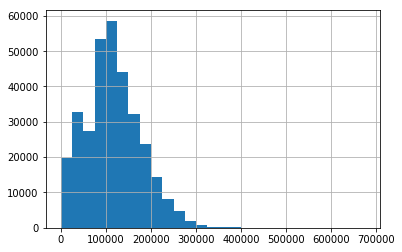

In [3]:
sf2017 = pd.read_csv('../data/sf2017.csv')
sf2017 = sf2017[sf2017.Salaries > 10000]
sf_bins = np.arange(0, 700000, 25000)
sf2017['Total Compensation'].hist(bins=sf_bins)

### Boostrap Function

A bootstrap function that takes in the population data and the size of the bootstrap sample. Iterates for 1,000 times then returns the list of bootstrapped medians. 

In [4]:
def bootstrap_median(data, bootstrap_sample_size):
    """Returns an array of bootstrapped sample medians:
    data: a list of the population data 
    bootstrap_sample_size: the size of the original sample from population (also the bootstrap resample size)
    """
    sample = np.random.choice(data, size=bootstrap_sample_size, replace=False)
    medians = np.array([])
    for i in np.arange(1000):
        bootstrap_sample = np.random.choice(data, bootstrap_sample_size)
        resampled_median = np.median(bootstrap_sample)
        medians = np.append(medians, resampled_median)
    return medians

## Plotly Integration 

### Plotly graph setup

First of all, using plotly requires a plotly account in which all your charts will be made public (freemium tier). This requires generating an api key to use in this notebook, details can be found [here](https://plot.ly/python/getting-started/). 

Now, in order to generate a graph that has interactive elements, an initial basic graph is required as the starting point. 

Here we create three basic histogram plots and place the population values in the first graph (for the final model). Then we set up the layout to have three graphs side by side and add each graph to the subplot. Finally, we plot the function.

Please note: This step saves your graph to a permanent URL. This step is only required for creating a completely new model. Rerunning the cell above will generate a new graph each time. Normally when running this tutorial, it is sufficient to use the url of the graph we have created: https://plot.ly/~calebs11/41/

In [ ]:
trace1 = {
  "x": sf2017['Total Compensation'].values,
  "opacity": 0.75, 
  "type": "histogram",
  "xbins":dict(
        start=0,
        end=500000,
        size=25000
    )
}
trace2 = {
  "opacity": 0.75, 
  "type": "histogram",
  "xbins":dict(
        start=0,
        end=500000,
        size=25000
    )
}
trace3 = {
  "opacity": 0.75, 
  "type": "histogram",
  "xbins":dict(
        start=0,
        end=500000,
        size=25000
    )
}
layout = {"barmode": "overlay"}
fig = plotly.tools.make_subplots(rows=1, cols=3)
fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace3, 1, 3)
plot_url = py.plot(fig)

Here we initialize a graph widget based on the graph in the url above. In the future, only running this line is enough. 

In [6]:
g = GraphWidget('https://plot.ly/~calebs11/41/')

### Creating slider widgets

Let's think about the way we want students to be able to interact with the graph. In this example, we want students to be able to modify the bootstrap sample size and the resample size to see how these two parameters change the way the histogram is shaped. 



In [7]:
style = {'description_width': 'initial'}
bootstrap_sample_size_slider = widgets.IntSlider(
    description='Bootstrap Sample Size',
    value=500, 
    max=1000, 
    min=1, 
    style=style, 
    continuous_update=False)
resample_size_slider = widgets.IntSlider(
    description='Resample Size',
    value=500, 
    max=1000, 
    min=1, 
    style=style) 

We create two sliders as part of the ipywidget library with an initial value of 500 each and a min max of 1 and 1000 respectively. The resample_size max of 1000 matches the number of iterations as defined in the bootstrap_median function. These numbers can be modified however be aware that increasing the size will increase computational time in the interactive model. In addition, we set continuous_update to false for the bootstrap sample slider so that the graph will not update until the user releases the mouse from the slider (reduce amount of computation which slows down the model). 

In [8]:
display(resample_size_slider, bootstrap_sample_size_slider)

A Jupyter Widget

A Jupyter Widget

By using a container, we can put the sliders side by side. 

In [9]:
container = widgets.HBox(children=[bootstrap_sample_size_slider, resample_size_slider])
display(container)

A Jupyter Widget

### Defining the update function (INTERACTION!!!!)

We begin by setting the initial conditions. Our current sample is a random list of bootstrapped medians based on the value of the bootstrap sample slider. We then create a list of medians which we can think of as the bootstrapped median list for this particular sample size. 

In [10]:
current_sample = bootstrap_median(sf2017['Total Compensation'].values, bootstrap_sample_size_slider.value)
resampled_medians = np.random.choice(current_sample, size=resample_size_slider.max, replace=True)

This is where the interactive portion takes place! This is the update function which gets triggered whenever a slider is moved. We set the current_sample and resampled_medians as global variables so that they will be saved in-between interactions. For example, if a student changes the bootstrap sample size, the sample from which we are resampling from must be updated as well as the current sample of values from the population. 

If the student only changes the resample size slider, then we only need to update the current bootstrap distribution and the final distribution graph. The graph updates by displaying a different set of values which you can see in the g.restyle function. We are inputting a different set of x value everytime this update function is called. 

In [11]:
def update(change):
    global current_sample
    global resampled_medians
    if (change['owner'].description) == 'Bootstrap Sample Size':  
        current_sample = bootstrap_median(sf2017['Total Compensation'].values, bootstrap_sample_size_slider.value)
        resampled_medians = np.random.choice(current_sample, size=resample_size_slider.max, replace=True)
    g.restyle({'x': [np.random.choice(current_sample, size=resample_size_slider.max, replace=True)], 'name': 'Resample Distribution', 'type': 'histogram', 
                   'opacity': 0.75}, indices=1) 
    g.restyle({'x': [resampled_medians[0:change['new']]], 'name': 'Bootstrap Medaians', 'type': 'histogram', 
                   'opacity': 0.75}, indices=2) 

We want the slider widgets to call the update function whenever a slider is moved and that the parameter being changed is the "value" attribute of the slider. We first tell the client to unobserve any linked sliders from previous calls and then tell the client to "observe" the bootstrap and resample size sliders. 

In [12]:
bootstrap_sample_size_slider.unobserve_all()
bootstrap_sample_size_slider.observe(update, names='value')
resample_size_slider.observe(update, names='value')

This final piece of code displays the sliders and graph widget!

In [13]:
container = widgets.HBox(children=[bootstrap_sample_size_slider, resample_size_slider])
display(container)
display(g)

A Jupyter Widget

A Jupyter Widget